<h1 align='center'><i>HLL-Riemann Solver</i></h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from typing import Callable

# ---

# TODO I've been getting some divide by zero problems that I plan to fix later
import warnings
warnings.filterwarnings("ignore")

<h2 align='center'>The Grid Class</h2>

In [2]:
class FVGrid:
    """
    Finite-volume grid class.
    """
    
    
    def __init__(self, num_x: int, num_g: int, x_min: float, x_max: float,
                 initial_conditions: Callable) -> None:
        
        """
        Initializes the grid with passed parameters.
        
        Parameters
        ----------
        num_x: int
            Number of real cells.
        num_g: int
            Number of ghost cells.
        x_min: float
            Cell value at lower end.
        x_max: float
            Cell value at upper end.
        initial_conditions: Callable
            Initializes array with a specific set of initial conditions.
            
        """
        
        self.num_x = num_x
        self.num_g = num_g
        self.num_cells = num_x + num_g * 2
        
        self.x_min = x_min
        self.x_max = x_max
        
        self.lo = num_g
        self.hi = num_x + num_g - 1
        
        # Interval between each cell
        self.dx = (x_max - x_min) / num_x
        
        # Cell values and interface values (physical coordinates)
        # The left interface of the first real cell is x_min
        # The right interface of the last real cell is x_max
        self.x_interf_l = \
            np.arange(0.0, self.num_cells * self.dx, self.dx) \
            + x_min - (num_g - 0.0) * self.dx
        self.x = \
            np.arange(0.0, self.num_cells * self.dx, self.dx) \
            + x_min - (num_g - 0.5) * self.dx
        self.x_interf_r = \
            np.arange(0.0, self.num_cells * self.dx, self.dx) \
            + x_min - (num_g - 1.0) * self.dx
        
        # Create grid of velocities
        self.u = self.newArray()
        self.u_init = self.newArray()
        
        assert initial_conditions != None, "Missing initial conditions."
        initial_conditions(self)
        
        self.fillBoundaryConditions(self.u)
        self.u_init[:] = self.u[:]
        

    def newArray(self) -> np.ndarray:
        """
        Returns new array dimensioned for our grid.

        Returns
        -------
        numpy.ndarray
            Array of zeros (float) of same shape of grid.
        
        """
        
        return np.zeros((self.num_cells), dtype=np.float64)
    
    
    def fillBoundaryConditions(self, array: np.ndarray) -> None:
        """
        Fills ghost cells with outflow boundary conditions.

        Parameters
        ----------
        array: numpy.ndarray
            Array to be filled with ghost cells.
        
        """
        
        # Left boundary
        array[:self.lo] = array[self.lo]
        # Right boundary
        array[self.hi+1:] = array[self.hi]

    
    def convergence(self, array: np.ndarray) -> float:
        """
        Returns the L2-norm of the passed array. This is used to assess the
        magnitude of errors in the solution.

        Parameters
        ----------
        array: numpy.ndarray
            Array we want to know the norm of.

        Returns
        ------
        float
            L2-norm of array.
        
        """

        assert len(array) == (self.num_cells), "Array has wrong length."
        
        # Calculate the L2-norm
        sum = np.sum(array[self.lo : self.hi+1] ** 2)
        norm = np.sqrt(self.dx * sum)
        
        return norm
    
    
    def plot(self):
        """
        Plots the grid.        
        """

        fig, ax = plt.subplots(figsize=(10,6))

        ax.set_title("Velocity $u$ on the Continuous Grid Cells")
        ax.set_xlabel("Position $x$")
        ax.set_ylabel("Velocity $u$")

        ax.plot(self.x, self.u_init,
                color="black", label="Initial Conditions")
        ax.plot(self.x, self.u, "--",
                color="red", label="Simulation")

        tmp = (self.u_init.max() - self.u_init.min()) * 0.1
        ax.set_xlim(self.x_interf_l[0], self.x_interf_r[-1])
        ax.set_ylim(self.u_init.min() - tmp,
                    self.u_init.max() + tmp)
                
        ax.legend()
        
        plt.close(fig)
        
        return fig, ax
        
    
    def __str__(self) -> str:
        """
        Provides a human-readable summary of the grid's structure.

        Returns
        -------
        str
            Lists the number of real and ghost cells, and the grid's min and
            max x-values.
        """
        
        values = [f"number of real cells:  {self.num_x}\n",
                  f"number of ghost cells: {self.num_g}\n",
                  f"minimum x: {self.x_min}\n",
                  f"maximum x: {self.x_max}\n"]
                  
        return ''.join(values)


    def __repr__(self) -> str:
        """
        Provides a constructor-style representation.

        Returns
        -------
        str
            A string that could be used to recreate the object.
            
        """
        return \
            f"FVGrid(num_x={self.num_x}, num_g={self.num_g}, " + \
            f"x_min={self.x_min}, x_max={self.x_max}), " + \
            f"initial_conditions={self.initial_conditions}"

<h2 align='center'>Initial Conditions</h2>

<h3><i>Shock</i></h3>

First, the original shock function (with all positive values). Then, the same function but shifted so we get mixed signs.

In [3]:
def f(x):
    return 1 + 1/2 * np.sin(6 * np.pi * (x - 1/3))


def shock(grid: FVGrid) -> None:
    """
    Calculates the speed following the first example.
    
    Parameter
    ---------
    grid: FVGrid
        Grid in which the shock speed will be calculated and updated.
        
    """
    
    # Initialize velocity
    condition1 = grid.x[:] < 1/3
    condition2 = (1/3 < grid.x[:]) & (grid.x[:] <= 2/3)
    condition3 = 2/3 <= grid.x[:]
    
    grid.u[condition1] = 1.0
    grid.u[condition2] = f(grid.x)[condition2]
    grid.u[condition3] = 1.0
    

def shock_alternative(grid: FVGrid) -> None:
    """
    Calculates the speed following the first example.
    
    Parameter
    ---------
    grid: FVGrid
        Grid in which the shock speed will be calculated and updated.
        
    """
    
    # Initialize velocity
    condition1 = grid.x[:] < 1/3
    condition2 = (1/3 < grid.x[:]) & (grid.x[:] <= 2/3)
    condition3 = 2/3 <= grid.x[:]
    
    grid.u[condition1] = 0.0
    grid.u[condition2] = f(grid.x)[condition2] - 1.0
    grid.u[condition3] = 0.0

<h3><i>Rarefaction</i></h3>

Similarly to the shock initial condition, we have an all positive initial condition for $u$. We also have one with mixed signs.

In [4]:
def rarefaction(grid: FVGrid) -> None:
    """
    Calculates the speed following the second example.
    
    Parameter
    ---------
    grid: FVGrid
        Grid in which the shock speed will be calculated and updated.
        
    """
    
    # Initialize velocity
    condition1 = grid.x[:] < 1/2
    condition2 = 1/2 <= grid.x[:]
    
    grid.u[condition1] = 1.0
    grid.u[condition2] = 2.0

    
def rarefaction_alternative(grid: FVGrid) -> None:
    """
    Calculates the speed following a step function.
    
    Parameter
    ---------
    grid: FVGrid
        Grid in which the shock speed will be calculated and updated.
        
    """
    
    # Initialize velocity
    condition1 = grid.x[:] < 1/2
    condition2 = 1/2 <= grid.x[:]
    
    grid.u[condition1] = -1.0
    grid.u[condition2] = +1.0

<h3><i>Alternative Function</i></h3>

I wanted to try a few different functions and I settled for this fun smooth random function I saw online. :)

In [5]:
def smooth_random(grid: FVGrid, sigma: float=0.02) -> None:
    """
    Smooth random initial condition using Gaussian convolution.

    Parameters
    ----------
    grid: FVGrid
        Grid object.
    sigma: float
        Smoothing scale (fraction of domain length).
    """
    
    rng = np.random.default_rng(0)
    # Draw random samples from a normal distribution
    noise = rng.normal(0.0, 1.0, grid.num_cells)

    # Gaussian kernel spanning ~4σ
    x = np.linspace(-0.5, 0.5, grid.num_cells)
    width = sigma * (grid.x_max - grid.x_min)
    kernel = np.exp(-0.5 * (x / width)**2)
    kernel /= kernel.sum()

    # Convolve and normalize
    u_smooth = np.convolve(noise, kernel, mode="same")
    u_smooth -= u_smooth.mean()
    u_smooth /= np.abs(u_smooth).max()

    grid.u[:] = u_smooth

<h2 align='center'>Advection</h2>

<h3><i>Flux & Flux Divergence</i></h3>

Compute the flux with
$$
F_{i+1/2} = \frac{1}{2}u_{i+1/2}^2.
$$

Compute the divergence of fluxes with
$$
\Delta F
    = - \frac{1}{\Delta x} (F_{i+1/2} - F_{i-1/2})
    = - \frac{1}{\Delta x} \bigg(
        \frac{1}{2}u_{i+1/2}^2 - \frac{1}{2}u_{i-1/2}^2
    \bigg).
$$

In [6]:
def F(u: np.ndarray) -> np.ndarray:
    """
    Computes the flux pointwise.
    
    Parameters
    ----------
    u: float
        Velocity array.
        
    Returns
    -------
    float
        Computed flux array.
        
    """
    
    return 1/2 * u**2

In [7]:
def dF(grid: FVGrid, f: np.ndarray) -> np.ndarray:
    """
    Computes the difference in flux between two center points pointwise.
    
    Parameters
    ----------
    grid: FVGrid
        Grid that provides the interval between cells.
    u: float
        Velocity array.
        
    Returns
    -------
    float
        Computed flux array.
        
    """
    
    return - 1 / grid.dx * (f[grid.lo+1 : grid.hi+2] - f[grid.lo : grid.hi+1])

<h3><i>The Riemann Problem</i></h3>

Let's work with flux on the Riemann problem.
$$
f_{i+1/2}
    = \left\{
        \begin{array}{ll}
            f^L & \quad\text{if}~ 0 \leq u^{\min} \\
            \frac{u^{\max} f^L - u^{\min} f^R + u^{\min}(u^R - u^L)}{u^{\max} - u^{\min}} & \quad\text{if}~ u^{\min} < 0 < u^{\max} \\
            f^R & \quad\text{if}~ u^{\max} \leq 0
        \end{array}
    \right .
$$

where
$$
u^{\min} = \min(u^L, u^R) \qquad u^{\max} = \max(u^L, u^R)
$$

In [8]:
def riemann(grid: FVGrid, u_interf_l: np.ndarray,
            u_interf_r: np.ndarray) -> np.ndarray:
    """
    Solves the Riemann problem.
    
    Parameters
    ----------
    grid: FVGrid
        Grid that provides the arrays.
    u_interf_l: numpy.ndarray
        Left interface.
    u_interf_r: numpy.ndarray
        Right interface.
        
    Returns
    -------
    numpy.ndarray
        The updated velocities.
    
    """
        
    u_min = grid.newArray()
    u_max = grid.newArray()
    
    u_min = np.minimum(u_interf_l, u_interf_r)
    u_max = np.maximum(u_interf_l, u_interf_r)
    
    condition1 = 0 <= u_min
    condition2 = (u_min < 0) & (0 < u_max)
    condition3 = u_max <= 0
    
    F_interf_l = F(u_interf_l)
    F_interf_r = F(u_interf_r)
    F_riemann = grid.newArray()
    
    F_riemann[condition1] = F_interf_l[condition1]
    F_riemann[condition2] = ((
              u_max * F_interf_l \
            - u_min * F_interf_r \
            + u_min * u_max * (u_interf_r - u_interf_l)
        ) / (u_max - u_min))[condition2]
    F_riemann[condition3] = F_interf_r[condition3]
    
    return F_riemann

<h3><i>Flux Update</i></h3>

In [9]:
def fluxUpdate(grid: FVGrid, u: np.ndarray) -> FVGrid:
    """
    Calculates the flux update.
    
    Parameters
    ----------
    grid: FVGrid
        Grid that provides the arrays.
    u: numpy.ndarray
        Array of velocities to update.
        
    Returns
    -------
    numpy.ndarray
        The flux update array.
    
    """
    
    lo = grid.lo
    hi = grid.hi
    
    # minmod_lhs = u(i) - u(i-1)
    minmod_lhs = grid.newArray()
    minmod_lhs[lo-1 : hi+2] = u[lo-1 : hi+2] - u[lo-2 : hi+1]

    # minmod_rhs = u(i+1) - u(i)
    minmod_rhs = grid.newArray()
    minmod_rhs[lo-1 : hi+2] = u[lo : hi+3] - u[lo-1 : hi+2]

    # Apply minmod conditions
    du_tmp = np.where(np.fabs(minmod_lhs) < np.fabs(minmod_rhs),
                      minmod_lhs,
                      minmod_rhs)
    du = np.where(minmod_lhs * minmod_rhs > 0.0, du_tmp, 0.0)

    # Up-winding means that we take the left state always
    # Convection: u_interf[i] = u_{i-0.5}
    u_interf_l = grid.newArray()
    u_interf_r = grid.newArray()
    
    u_interf_l[lo : hi+2] = u[lo-1 : hi+1] + du[lo-1 : hi+1] / 2
    u_interf_r[lo : hi+2] = u[lo : hi+2] + du[lo : hi+2] / 2

    F_riemann = riemann(grid, u_interf_l, u_interf_r)
    dF_riemann = grid.newArray()
    
    dF_riemann[lo : hi+1] = dF(grid, F_riemann)

    return dF_riemann


<h3><i>Second-Order Advection</i></h3>

In [10]:
def advection(grid: FVGrid, C: float, t_max: float) -> FVGrid:
    """
    Calculate the advection for the grid.
    
    Parameters
    ----------
    grid: FVGrid
        Grid that has the information.
    C: float
        Courant number.
    t_max: float
        Maximum time.
        
    Returns
    -------
    FVGrid
        Grid after process is complete.
    
    """
    
    t = 0.0 # time starts at 0.0
    while t < t_max:
        
        dt = C * grid.dx / np.abs(grid.u).max()
        
        # Account for when time would exceed maximum time
        if t + dt > t_max:
            dt = t_max - t
        
        
        # Second order Runge-Kutta integration
        grid.fillBoundaryConditions(grid.u)
        dflux1 = fluxUpdate(grid, grid.u)
        
        u_tmp = grid.newArray()
        u_tmp[:] = grid.u[:] + 1/2 * dt * dflux1[:]
        
        grid.fillBoundaryConditions(u_tmp)
        dflux2 = fluxUpdate(grid, u_tmp)
        
        grid.u[:] += dt * dflux2[:]
        
        t += dt
    
    return grid

<h2 align='center'>Simulation</h2>

In [11]:
num_x = 512
num_g = 2
x_min = 0.0
x_max = 1.0

C = 0.5
t_max = 0.2

<h3><i>Initial Condition: Shock</i></h3>

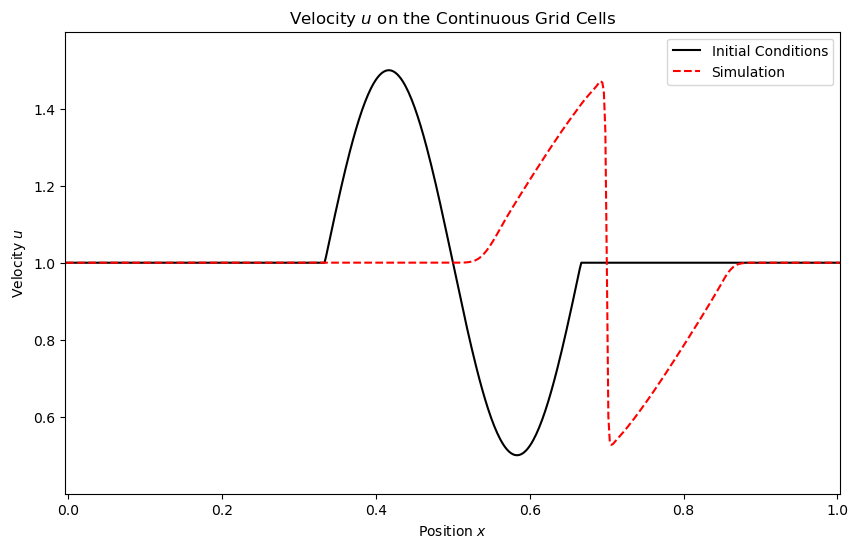

In [12]:
grid = FVGrid(num_x=num_x, num_g=num_g, x_min=x_min, x_max=x_max,
              initial_conditions=shock)
advection(grid, C, t_max)

fig, ax = grid.plot()
fig

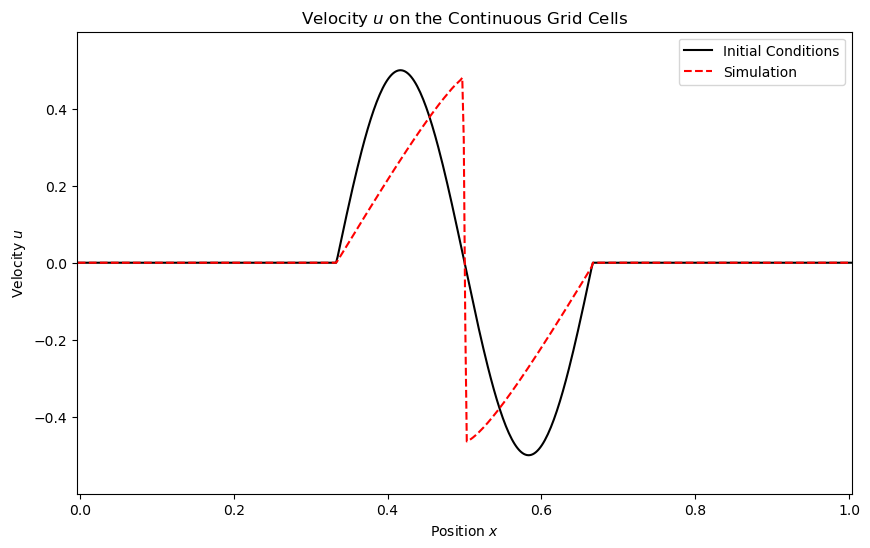

In [13]:
grid = FVGrid(num_x=num_x, num_g=num_g, x_min=x_min, x_max=x_max,
              initial_conditions=shock_alternative)
advection(grid, C, t_max)

fig, ax = grid.plot()
fig

<h3><i>Initial Condition: Rarefaction</i></h3>

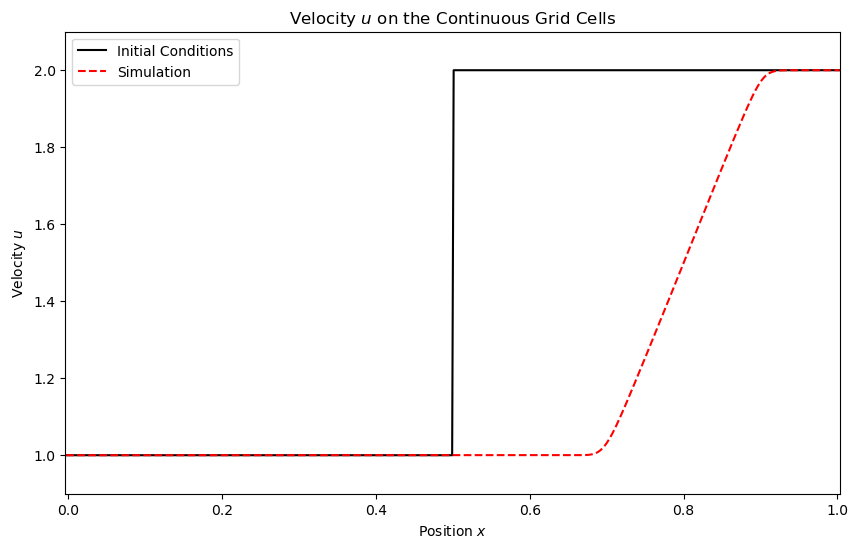

In [14]:
grid = FVGrid(num_x=num_x, num_g=num_g, x_min=x_min, x_max=x_max,
              initial_conditions=rarefaction)
advection(grid, C, t_max)

fig, ax = grid.plot()
fig

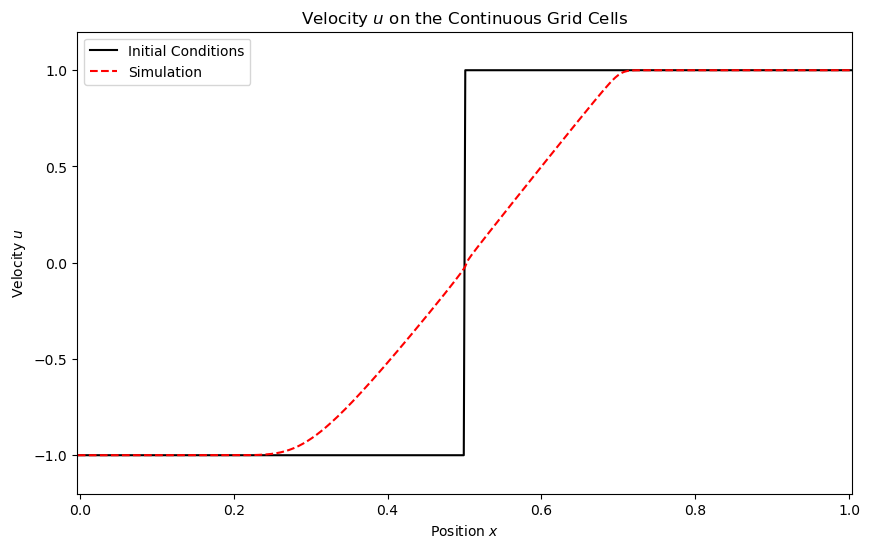

In [15]:
grid = FVGrid(num_x=num_x, num_g=num_g, x_min=x_min, x_max=x_max,
              initial_conditions=rarefaction_alternative)
advection(grid, C, t_max)

fig, ax = grid.plot()
fig

<h3><i>Initial Condition: Smooth Random Function</i></h3>

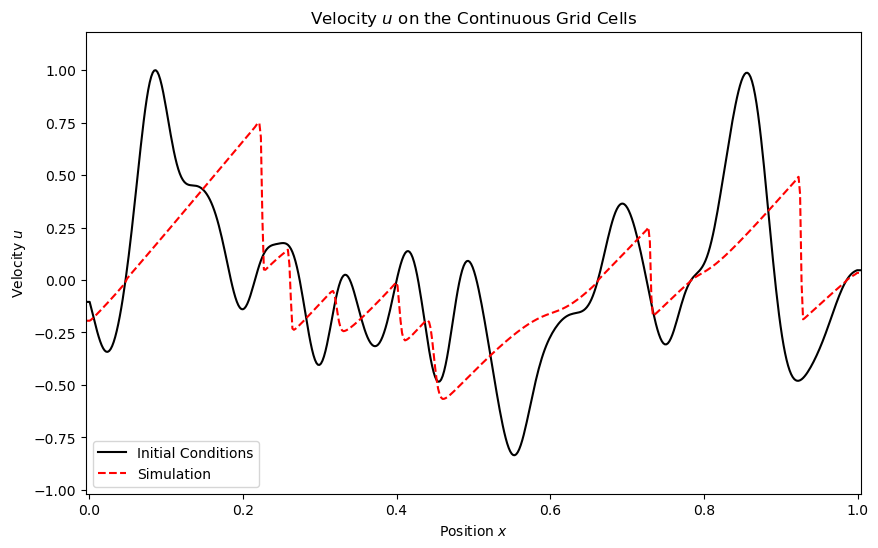

In [16]:
grid = FVGrid(num_x=num_x, num_g=num_g, x_min=x_min, x_max=x_max,
              initial_conditions=smooth_random)
advection(grid, C, t_max)

fig, ax = grid.plot()
fig